## The value the model seeks to predict is the `mvp_share` column, which represents the result of the MVP voting for each season.

### mvp_share $= \frac{PtsWon}{PtsMax}$

In [1]:
import os
os.chdir('/sfs/qumulo/qhome/bdr6qz/Documents/MSDS/DS6050')
from helper_functions import (print_importances, 
                              print_dict_imps, 
                              avg_imps, 
                              percent_formatter, 
                              plot_comparison_for_season)

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

import joblib
# Load the best model from Models.ipynb
best_model = joblib.load('best_model.pkl')

In [2]:
# Load the data
df_selected = pd.read_csv('df_selected.csv')
features = list(df_selected.columns) + ['mvp_share', 'Rank']
df_train = pd.read_csv('df_clean.csv', usecols=features)
labels = df_train.pop('mvp_share')
stratify = df_train.pop('Rank')
del features[10:12]
features.extend(['Season', 'name'])
df_test = pd.read_csv('df_last.csv', usecols=features)
df_test.rename(columns={'name': 'Name'}, inplace=True)
del features[10:12]

In [3]:
(X_train, X_test, y_train, y_test) = train_test_split(df_train, 
                                                      labels, 
                                                      test_size=0.2, 
                                                      shuffle=True, 
                                                      random_state=28, 
                                                      stratify=stratify)

# Convert each dataset to array
y_train = y_train.values
y_test = y_test.values
X_train = X_train.values
X_test = X_test.values

#### Use the best model from `Models.ipynb`

In [4]:
best_model.fit(X_train, y_train)

ExtraTreesRegressor(max_depth=10, max_features=None, min_samples_split=10,
                    random_state=28)

In [5]:
# Make predictions on the test data using the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test R-squared:", r2)

Test MSE: 0.0011482336163636244
Test R-squared: 0.7749970844753004


---

## Testing

In [6]:
dfs_n_last = []
for season_n, df_n in df_test.groupby('Season'):
    feature_n = df_n.drop(['Season', 'Name'], axis=1).values
    prediction = best_model.predict(feature_n)
    df_curr = pd.DataFrame(data=feature_n, columns=features)
    df_curr['Season'] = season_n
    df_curr['name'] = df_n['Name'].values
    df_curr['predicted'] = prediction * 100
    df_curr = df_curr.sort_values(by='predicted', ascending=False).reset_index(drop=True)
    dfs_n_last.append(df_curr)

df_pred = pd.concat(dfs_n_last, ignore_index=True)

### Compare Against True Share

In [7]:
keep = list(df_pred.columns)
del keep[12]
keep.append('mvp_share')
df_full = pd.read_csv('mvp_data_edit.csv', usecols=keep)
# Merge df_pred with df_full on "name" and "Season" columns
merged_df = pd.merge(df_pred, df_full[['name', 'Season', 'mvp_share']], 
                     on=['name', 'Season'], how='left')
# Rename the 'mvp_share' column to 'actual' in the merged dataframe
merged_df.rename(columns={'mvp_share': 'actual'}, inplace=True)
merged_df['actual'] *= 100

In [9]:
# Iterate over unique values in the 'Season' column and create separate plots for each
unique_seasons = merged_df['Season'].unique()

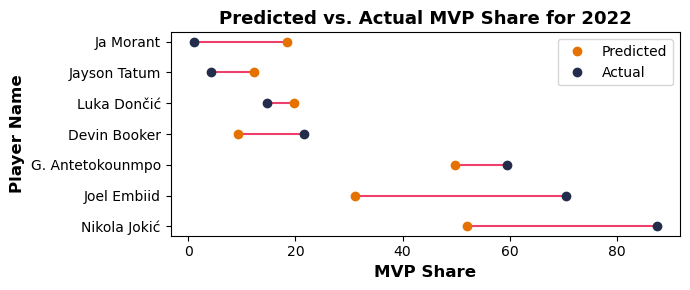

In [10]:
plot_comparison_for_season(merged_df, 2022)

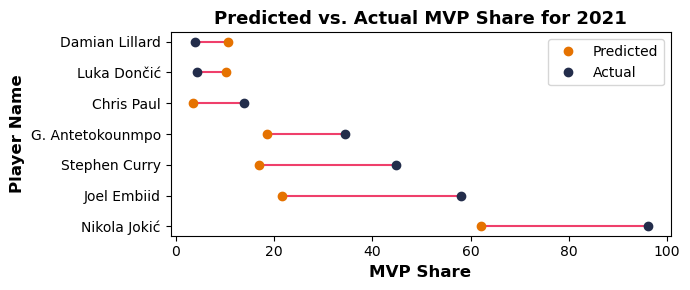

In [11]:
plot_comparison_for_season(merged_df, 2021)

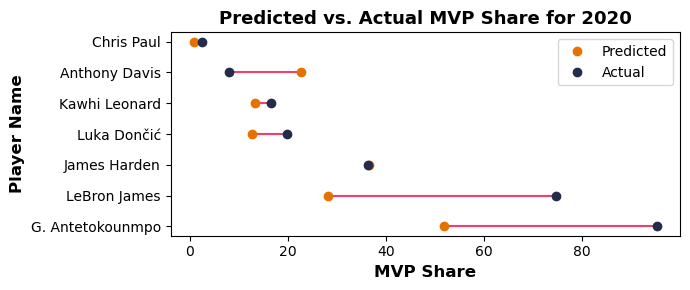

In [12]:
plot_comparison_for_season(merged_df, 2020)

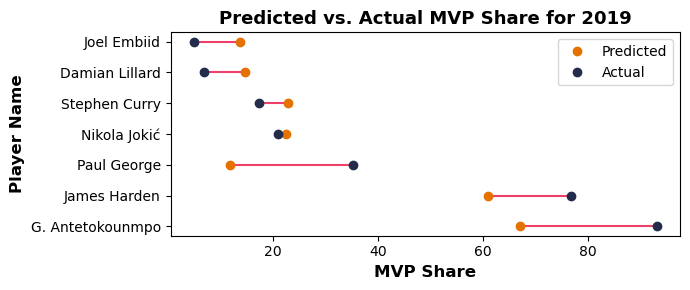

In [13]:
plot_comparison_for_season(merged_df, 2019)

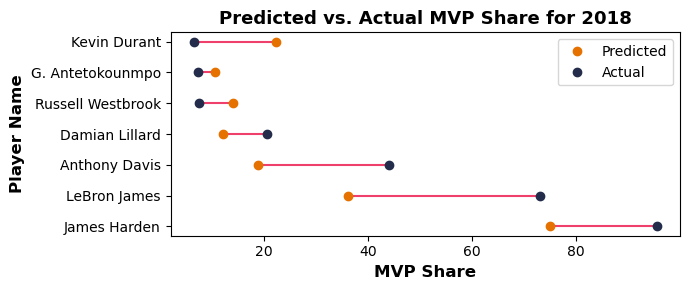

In [14]:
plot_comparison_for_season(merged_df, 2018)

In [19]:
# Load full dataset from Cleaning_EDA.ipynb
df_results = pd.read_csv('mvp_data_edit.csv')

# Filter columns and seasons
df_results = df_results.drop(columns=['conference', 'W']).query('Season >= 1980')

# Calculate and add the index column
feature_importances = best_model.feature_importances_
normalized_importances = feature_importances / np.sum(feature_importances)
index_values = np.dot(df_results[features].values, normalized_importances)
df_results['index'] = index_values

# Rank the index within each season group
df_results['Ranked_Index'] = df_results.groupby('Season')['index'].rank(ascending=False)

# Save to a separate csv
df_results.to_csv('results.csv', index=False)